In [10]:
import pandas as pd
import os.path
import cPickle as cpickle
import numpy as np
import keras.utils
import time
from keras.callbacks import TensorBoard, CSVLogger

In [11]:
data_set = pd.read_table('liar_dataset/train.tsv',
                         names = ["label", "statement", "subject", "speaker", "job", "state", "party", "venue"])

In [12]:
data_set.head(5)

,label,statement,subject,speaker,job,state,party,venue
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,a mailer
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,Denver
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,a news release
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,an interview on CNN


In [13]:
#Using pretrained word embeddings (an experiment)
#Read glove vectors and get unique words in an array
embeddings_index = {}
with open('/Users/vivekpradhan/Downloads/glove.6B/glove.6B.100d.txt') as fp:
    for line in fp:
        values = line.split()
        vectors = np.asarray(values[1:], dtype='float32')
        embeddings_index[values[0].lower()] = vectors
print "File reading is done"
print('Found %s word vectors.' % len(embeddings_index))

File reading is done
Found 400000 word vectors.


In [14]:
EMBEDDING_DIM = 100

In [15]:
val_set = pd.read_table('liar_dataset/valid.tsv',
                         names = ["label", "statement", "subject", "speaker", "job", "state", "party", "venue"])

In [16]:
test_set = pd.read_csv('liar_dataset/test.tsv',sep='\t')

In [17]:
counter = 0
test_data = []
with open('liar_dataset/test.tsv') as test_fp: 
    for line in test_fp:
        line = line.strip('\n')
        test_item = line.split('\t')
        test_data.append(test_item)
        counter += 1
print 'Length of test set '+str(len(test_data))

Length of test set 1283


In [18]:
test_data[0]

['Building a wall on the U.S.-Mexico border will take literally years.',
 'immigration',
 'rick-perry',
 'Governor',
 'Texas',
 'republican',
 'Radio interview']

In [19]:
test_set = pd.DataFrame(test_data,columns=["statement", "subject", "speaker", "job", "state", "party", "venue"])

In [9]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1283 entries, 0 to 1282
Data columns (total 7 columns):
statement    1283 non-null object
subject      1283 non-null object
speaker      1283 non-null object
job          1283 non-null object
state        1283 non-null object
party        1283 non-null object
venue        1283 non-null object
dtypes: object(7)
memory usage: 70.2+ KB


In [20]:
label_dict = {'pants-fire':0,'false':1,'barely-true':2,'half-true':3,'mostly-true':4,'true':5}
label_reverse_arr = ['pants-fire','false','barely-true','half-true','mostly-true','true']

In [21]:
def create_one_hot(x):
    return keras.utils.to_categorical(label_dict[x],num_classes=6)
data_set['label_id'] = data_set['label'].apply(lambda x: label_dict[x])
val_set['label_id'] = val_set['label'].apply(lambda x: label_dict[x])
val_set.head(3)

,label,statement,subject,speaker,job,state,party,venue,label_id
0,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,an interview with ABC17 News,2
1,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,NaN,0
2,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,a U.S. Ways and Means hearing,1


In [22]:
speakers = ['barack-obama', 'donald-trump', 'hillary-clinton', 'mitt-romney', 
            'scott-walker', 'john-mccain', 'rick-perry', 'chain-email', 
            'marco-rubio', 'rick-scott', 'ted-cruz', 'bernie-s', 'chris-christie', 
            'facebook-posts', 'charlie-crist', 'newt-gingrich', 'jeb-bush', 
            'joe-biden', 'blog-posting','paul-ryan']
speaker_dict = {}
for cnt,speaker in enumerate(speakers):
    speaker_dict[speaker] = cnt
print speaker_dict
def map_speaker(speaker):
    if isinstance(speaker, basestring):
        speaker = speaker.lower()
        matches = [s for s in speakers if s in speaker]
        if len(matches) > 0:
            return speaker_dict[matches[0]] #Return index of first match
        else:
            return len(speakers)
    else:
        return len(speakers) #Nans or un-string data goes here.
data_set['speaker_id'] = data_set['speaker'].apply(map_speaker)
val_set['speaker_id'] = val_set['speaker'].apply(map_speaker)
print len(speakers)

{'marco-rubio': 8, 'mitt-romney': 3, 'chain-email': 7, 'bernie-s': 11, 'newt-gingrich': 15, 'rick-perry': 6, 'hillary-clinton': 2, 'chris-christie': 12, 'facebook-posts': 13, 'charlie-crist': 14, 'john-mccain': 5, 'barack-obama': 0, 'joe-biden': 17, 'blog-posting': 18, 'paul-ryan': 19, 'jeb-bush': 16, 'donald-trump': 1, 'scott-walker': 4, 'rick-scott': 9, 'ted-cruz': 10}
20


In [23]:
data_set['job'].value_counts()[:10]
job_list = ['president', 'u.s. senator', 'governor', 'president-elect', 'presidential candidate', 
            'u.s. representative', 'state senator', 'attorney', 'state representative', 'congress']

job_dict = {'president':0, 'u.s. senator':1, 'governor':2, 'president-elect':3, 'presidential candidate':4, 
            'u.s. representative':5, 'state senator':6, 'attorney':7, 'state representative':8, 'congress':9}
#Possible groupings could be (11 groups)
#president, us senator, governor(contains governor), president-elect, presidential candidate, us representative,
#state senator, attorney, state representative, congress (contains congressman or congresswoman), rest
def map_job(job):
    if isinstance(job, basestring):
        job = job.lower()
        matches = [s for s in job_list if s in job]
        if len(matches) > 0:
            return job_dict[matches[0]] #Return index of first match
        else:
            return 10 #This maps any other job to index 10
    else:
        return 10 #Nans or un-string data goes here.
data_set['job_id'] = data_set['job'].apply(map_job)
val_set['job_id'] = val_set['job'].apply(map_job)

In [24]:
#data_set.head(5)

In [25]:
data_set['party'].value_counts()
#Possible groupings (6 groups)
#Hyper param -> num_party
party_dict = {'republican':0,'democrat':1,'none':2,'organization':3,'newsmaker':4}
#default index for rest party is 5
def map_party(party):
    if party in party_dict:
        return party_dict[party]
    else:
        return 5
data_set['party_id'] = data_set['party'].apply(map_party)
val_set['party_id'] = val_set['party'].apply(map_party)

In [26]:
#print data_set['state'].value_counts()[0:50]
#Possible groupings (50 groups + 1 for rest)
states = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado',
         'Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho', 
         'Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana',
         'Maine' 'Maryland','Massachusetts','Michigan','Minnesota',
         'Mississippi', 'Missouri','Montana','Nebraska','Nevada',
         'New Hampshire','New Jersey','New Mexico','New York',
         'North Carolina','North Dakota','Ohio',    
         'Oklahoma','Oregon','Pennsylvania','Rhode Island',
         'South  Carolina','South Dakota','Tennessee','Texas','Utah',
         'Vermont','Virginia','Washington','West Virginia',
         'Wisconsin','Wyoming']
#states_dict = {}
#i = 0
#for state in states:
#    state_key = state.lower()
#    states_dict[state_key] = i
#    i += 1
#print len(states_dict.keys())

states_dict = {'wyoming': 48, 'colorado': 5, 'washington': 45, 'hawaii': 10, 'tennessee': 40, 'wisconsin': 47, 'nevada': 26, 'north dakota': 32, 'mississippi': 22, 'south dakota': 39, 'new jersey': 28, 'oklahoma': 34, 'delaware': 7, 'minnesota': 21, 'north carolina': 31, 'illinois': 12, 'new york': 30, 'arkansas': 3, 'west virginia': 46, 'indiana': 13, 'louisiana': 17, 'idaho': 11, 'south  carolina': 38, 'arizona': 2, 'iowa': 14, 'mainemaryland': 18, 'michigan': 20, 'kansas': 15, 'utah': 42, 'virginia': 44, 'oregon': 35, 'connecticut': 6, 'montana': 24, 'california': 4, 'massachusetts': 19, 'rhode island': 37, 'vermont': 43, 'georgia': 9, 'pennsylvania': 36, 'florida': 8, 'alaska': 1, 'kentucky': 16, 'nebraska': 25, 'new hampshire': 27, 'texas': 41, 'missouri': 23, 'ohio': 33, 'alabama': 0, 'new mexico': 29}
def map_state(state):
    if isinstance(state, basestring):
        state = state.lower()
        if state in states_dict:
            return states_dict[state]
        else:
            if 'washington' in state:
                return states_dict['washington']
            else:
                return 50 #This maps any other location to index 50
    else:
        return 50 #Nans or un-string data goes here.
data_set['state_id'] = data_set['state'].apply(map_state)
val_set['state_id'] = val_set['state'].apply(map_state)

In [27]:
#

In [28]:
data_set['subject'].value_counts()[0:5]
#Possible groups (14)
subject_list = ['health','tax','immigration','election','education',
'candidates-biography','economy','gun','jobs','federal-budget','energy','abortion','foreign-policy']

subject_dict = {'health':0,'tax':1,'immigration':2,'election':3,'education':4,
'candidates-biography':5,'economy':6,'gun':7,'jobs':8,'federal-budget':9,'energy':10,'abortion':11,'foreign-policy':12}
#health-care,taxes,immigration,elections,education,candidates-biography,guns,
#economy&jobs ,federal-budget,energy,abortion,foreign-policy,state-budget, rest
#Economy & Jobs is bundled together, because it occurs together
def map_subject(subject):
    if isinstance(subject, basestring):
        subject = subject.lower()
        matches = [s for s in subject_list if s in subject]
        if len(matches) > 0:
            return subject_dict[matches[0]] #Return index of first match
        else:
            return 13 #This maps any other subject to index 13
    else:
        return 13 #Nans or un-string data goes here.

data_set['subject_id'] = data_set['subject'].apply(map_subject)
val_set['subject_id'] = val_set['subject'].apply(map_subject)

In [29]:
data_set['venue'].value_counts()[0:15]

venue_list = ['news release','interview','tv','radio',
              'campaign','news conference','press conference','press release',
              'tweet','facebook','email']
venue_dict = {'news release':0,'interview':1,'tv':2,'radio':3,
              'campaign':4,'news conference':5,'press conference':6,'press release':7,
              'tweet':8,'facebook':9,'email':10}
def map_venue(venue):
    if isinstance(venue, basestring):
        venue = venue.lower()
        matches = [s for s in venue_list if s in venue]
        if len(matches) > 0:
            return venue_dict[matches[0]] #Return index of first match
        else:
            return 11 #This maps any other venue to index 11
    else:
        return 11 #Nans or un-string data goes here.
#possibe groups (12)
#news release, interview, tv (television), radio, campaign, news conference, press conference, press release,
#tweet, facebook, email, rest
data_set['venue_id'] = data_set['venue'].apply(map_venue)
val_set['venue_id'] = val_set['venue'].apply(map_venue)

In [30]:
#Tokenize statement and vocab test
vocab_dict = {}
from keras.preprocessing.text import Tokenizer
if not os.path.exists('vocab.p'):
    t = Tokenizer()
    t.fit_on_texts(data_set['statement'])
    vocab_dict = t.word_index
    cpickle.dump( t.word_index, open( "vocab.p", "wb" ))
    print 'Vocab dict is created'
    print 'Saved vocab dict to pickle file'
else:
    print 'Loading vocab dict from pickle file'
    vocab_dict = cpickle.load(open("vocab.p", "rb" ))

Loading vocab dict from pickle file


In [31]:
#Get all preprocessing done for test data
test_set['job_id'] = test_set['job'].apply(map_job) #Job
test_set['party_id'] = test_set['party'].apply(map_party) #Party
test_set['state_id'] = test_set['state'].apply(map_state) #State
test_set['subject_id'] = test_set['subject'].apply(map_subject) #Subject
test_set['venue_id'] = test_set['venue'].apply(map_venue) #Venue
test_set['speaker_id'] = test_set['speaker'].apply(map_speaker) #Speaker

In [32]:
test_set.head(3)

,statement,subject,speaker,job,state,party,venue,job_id,party_id,state_id,subject_id,venue_id,speaker_id
0,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,Radio interview,2,0,41,2,1,6
1,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,a news conference,8,1,47,8,5,20
2,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,comments on ABC's This Week.,0,0,30,13,11,1


In [33]:
#To access particular word_index. Just load these.
#To read a word in a sentence use keras tokenizer again, coz easy
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing import sequence
#text = text_to_word_sequence(data_set['statement'][0])
#print text
#val = [vocab_dict[t] for t in text]
#print val

def pre_process_statement(statement):
    text = text_to_word_sequence(statement)
    val = [0] * 10
    val = [vocab_dict[t] for t in text if t in vocab_dict] #Replace unk words with 0 index
    return val

In [34]:
#Creating embedding matrix to feed in embeddings directly bruv
num_words = len(vocab_dict) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in vocab_dict.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [35]:
#I have reset embeddings_index since it would take a lot of memory
embeddings_index = None

In [36]:
#Hyper parameter definitions
vocab_length = len(vocab_dict.keys())
hidden_size = 100 #Has to be same as EMBEDDING_DIM
lstm_size = 100
num_steps = 25
num_epochs = 30
batch_size = 40
#Hyperparams for CNN
kernel_sizes = [2,5,8]
filter_size = 128
#Meta data related hyper params
num_party = 6
num_state = 51
num_venue = 12
num_job = 11
num_sub = 14
num_speaker = 21

In [37]:
#Load data and pad sequences to prepare training, validation and test data
data_set['word_ids'] = data_set['statement'].apply(pre_process_statement)
val_set['word_ids'] = val_set['statement'].apply(pre_process_statement)
test_set['word_ids'] = test_set['statement'].apply(pre_process_statement)
X_train = data_set['word_ids']
Y_train = data_set['label_id']
X_val = val_set['word_ids']
Y_val = val_set['label_id']
X_test = test_set['word_ids']
X_train = sequence.pad_sequences(X_train, maxlen=num_steps, padding='post',truncating='post')
Y_train = keras.utils.to_categorical(Y_train, num_classes=6)
X_val = sequence.pad_sequences(X_val, maxlen=num_steps, padding='post',truncating='post')
Y_val = keras.utils.to_categorical(Y_val, num_classes=6)
X_test = sequence.pad_sequences(X_test, maxlen=num_steps, padding='post',truncating='post')

In [38]:
#Meta data preparation
a = keras.utils.to_categorical(data_set['party_id'], num_classes=num_party)
b = keras.utils.to_categorical(data_set['state_id'], num_classes=num_state)
c = keras.utils.to_categorical(data_set['venue_id'], num_classes=num_venue)
d = keras.utils.to_categorical(data_set['job_id'], num_classes=num_job)
e = keras.utils.to_categorical(data_set['subject_id'], num_classes=num_sub)
f = keras.utils.to_categorical(data_set['speaker_id'], num_classes=num_speaker)
X_train_meta = np.hstack((a,b,c,d,e,f))#concat a and b
a_val = keras.utils.to_categorical(val_set['party_id'], num_classes=num_party)
b_val = keras.utils.to_categorical(val_set['state_id'], num_classes=num_state)
c_val = keras.utils.to_categorical(val_set['venue_id'], num_classes=num_venue)
d_val = keras.utils.to_categorical(val_set['job_id'], num_classes=num_job)
e_val = keras.utils.to_categorical(val_set['subject_id'], num_classes=num_sub)
f_val = keras.utils.to_categorical(val_set['speaker_id'], num_classes=num_speaker)
X_val_meta = np.hstack((a_val,b_val,c_val,d_val,e_val,f_val))#concat a_val and b_val
a_test = keras.utils.to_categorical(test_set['party_id'], num_classes=num_party)
b_test = keras.utils.to_categorical(test_set['state_id'], num_classes=num_state)
c_test = keras.utils.to_categorical(test_set['venue_id'], num_classes=num_venue)
d_test = keras.utils.to_categorical(test_set['job_id'], num_classes=num_job)
e_test = keras.utils.to_categorical(test_set['subject_id'], num_classes=num_sub)
f_test = keras.utils.to_categorical(test_set['speaker_id'], num_classes=num_speaker)
X_test_meta = np.hstack((a_test,b_test,c_test,d_test,e_test,f_test))#concat all test data

In [39]:
Y_val.shape

(1284, 6)

In [40]:
X_train_meta.shape

(10240, 115)

In [41]:
from keras.models import Sequential
from keras.layers import Dense,Flatten,LSTM,Conv1D,GlobalMaxPool1D,Dropout
from keras.layers.embeddings import Embedding
from keras import optimizers

In [150]:
#Keras LSTM Model (defining sequential model simple)
model = Sequential()
model.add(Embedding(vocab_length+1, hidden_size, input_length=num_steps))
model.add(LSTM(hidden_size))
model.add(Dense(6, activation='softmax'))

In [42]:
#Defining a complex model. Adding meta data features to the model (LSTM Based)
from keras.layers import Input
from keras.models import Model
statement_input = Input(shape=(num_steps,), dtype='int32', name='main_input')
x = Embedding(vocab_length+1,EMBEDDING_DIM,weights=[embedding_matrix],input_length=num_steps,trainable=False)(statement_input) #Preloaded glove embeddings
#x = Embedding(output_dim=hidden_size, input_dim=vocab_length+1, input_length=num_steps)(statement_input) #Train embeddings from scratch
lstm_in = LSTM(lstm_size,dropout=0.2)(x)
meta_input = Input(shape=(X_train_meta.shape[1],), name='aux_input')
#x_em = Embedding(output_dim=hidden_size, input_dim=2, input_length=X_train_meta.shape[1])(meta_input)
x_meta = Dense(64, activation='relu')(meta_input)
#x_meta = Dense(56, activation='relu')(x_meta)
x = keras.layers.concatenate([lstm_in, x_meta])
#x = Dense(128, activation='relu')(x) #Add some density
#x = Dense(64, activation='relu')(x) #Add some density
#x = Dense(32, activation='relu')(x) #Add some density
main_output = Dense(6, activation='softmax', name='main_output')(x)
model = Model(inputs=[statement_input, meta_input], outputs=[main_output])

In [189]:
#Defining a complex model. Adding meta data features to the model (CNN Based)
from keras.layers import Input
from keras.models import Model

kernel_arr = []
statement_input = Input(shape=(num_steps,), dtype='int32', name='main_input')
#x = Embedding(vocab_length+1,EMBEDDING_DIM,weights=[embedding_matrix],input_length=num_steps,trainable=False)(statement_input) #Preloaded glove embeddings
x = Embedding(output_dim=hidden_size, input_dim=vocab_length+1, input_length=num_steps)(statement_input) #Train embeddings from scratch

for kernel in kernel_sizes:
    x_1 = Conv1D(filters=filter_size,kernel_size=kernel)(x)
    x_1 = GlobalMaxPool1D()(x_1)
    kernel_arr.append(x_1)
conv_in = keras.layers.concatenate(kernel_arr)
conv_in = Dropout(0.6)(conv_in)
conv_in = Dense(128, activation='relu')(conv_in)

#Meta input
meta_input = Input(shape=(X_train_meta.shape[1],), name='aux_input')
#x_em = Embedding(output_dim=hidden_size, input_dim=2, input_length=X_train_meta.shape[1])(meta_input)
x_meta = Dense(64, activation='relu')(meta_input)
#x_meta = Dense(56, activation='relu')(x_meta)
x = keras.layers.concatenate([conv_in, x_meta])
#x = Dense(128, activation='relu')(x) #Add some density
#x = Dense(64, activation='relu')(x) #Add some density
#x = Dense(32, activation='relu')(x) #Add some density
main_output = Dense(6, activation='softmax', name='main_output')(x)
model = Model(inputs=[statement_input, meta_input], outputs=[main_output])

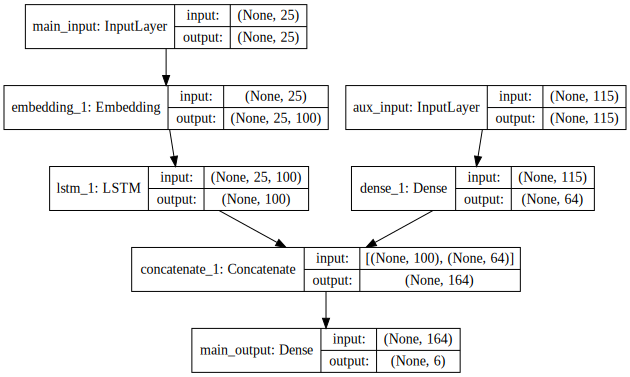

In [44]:
#Visualize model
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_lstm.png', show_shapes=True, show_layer_names=True)
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [123]:
#Compile model and print summary
#Define specific optimizer to counter over-fitting
sgd = optimizers.SGD(lr=0.025, clipvalue=0.3, nesterov=True)
adam = optimizers.Adam(lr=0.000075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['categorical_accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 25, 100)      1237800     main_input[0][0]                 
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 115)          0                                            
__________________________________________________________________________________________________
lstm_13 (LSTM)                  (None, 100)          80400       embedding_13[0][0]               
__________________________________________________________________________________________________
dense_13 (

In [117]:
#Start training the sequential model here
#model.fit(X_train,Y_train,batch_size=10,epochs=10,verbose=1,validation_data=(X_val,Y_val))

In [124]:
#Output stuff to tensorboard and write csv too. So I will define some callbacks
tb = TensorBoard()
csv_logger = keras.callbacks.CSVLogger('run/training.log')
filepath= "weights.best.hdf5"
#Or use val_loss depending on whatever the heck you want
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

In [125]:
#Start training the functional model here

model.fit({'main_input': X_train, 'aux_input': X_train_meta},
          {'main_output': Y_train},epochs=num_epochs, batch_size=batch_size,
          validation_data=({'main_input': X_val, 'aux_input': X_val_meta},{'main_output': Y_val}),
         callbacks=[tb,csv_logger,checkpoint])

Train on 10240 samples, validate on 1284 samples
Epoch 1/30
10240/10240 [==============================] - 24s 2ms/step - loss: 1.7560 - categorical_accuracy: 0.2154 - val_loss: 1.7390 - val_categorical_accuracy: 0.2375

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23754, saving model to weights.best.hdf5
Epoch 2/30
10240/10240 [==============================] - 24s 2ms/step - loss: 1.7390 - categorical_accuracy: 0.2282 - val_loss: 1.7252 - val_categorical_accuracy: 0.2438

Epoch 00002: val_categorical_accuracy improved from 0.23754 to 0.24377, saving model to weights.best.hdf5
Epoch 3/30
10240/10240 [==============================] - 24s 2ms/step - loss: 1.7277 - categorical_accuracy: 0.2353 - val_loss: 1.7143 - val_categorical_accuracy: 0.2422

Epoch 00003: val_categorical_accuracy did not improve
Epoch 4/30
10240/10240 [==============================] - 23s 2ms/step - loss: 1.7195 - categorical_accuracy: 0.2458 - val_loss: 1.7047 - val_categorical_accuracy: 0.2640



# Accuracy result for basic LSTM with just word embeddings and time steps 25
#84s 8ms/step - loss: 1.0017 - categorical_accuracy: 0.6376 - val_loss: 2.2503 - val_categorical_accuracy: 0.2298
'''
hidden_size = 50
num_steps = 25
num_epochs = 20
batch_size = 20
'''
#Accuracy result for basic LSTM with word embeddings, party and state infor and time steps 25
#42s 4ms/step - loss: 0.5065 - categorical_accuracy: 0.8275 - val_loss: 3.2041 - val_categorical_accuracy: 0.2118

'''
hidden_size = 128
num_steps = 25
num_epochs = 32
batch_size = 32
'''
#Accuracy result for basic LSTM with word embeddings, party,state,venue,job,subject and epochs 32
#33s 3ms/step - loss: 0.1056 - categorical_accuracy: 0.9640 - val_loss: 6.3742 - val_categorical_accuracy: 0.2399

In [34]:
from keras.models import load_model
#Load a pre-trained model if any
model1 = load_model('weights.best_lstm1.hdf5')

In [35]:
#Make predictions on test set
preds = model1.predict([X_test,X_test_meta], batch_size=batch_size, verbose=1)

1283/1283 [==============================] - 1s 554us/step


In [36]:
print len(preds)
print label_reverse_arr[np.argmax(preds[0])]

1283
false


In [37]:
#Write data to file
vf = open('predictions.txt', 'w+')
counter = 0
for pred in preds:  
    line_string = label_reverse_arr[np.argmax(pred)]
    vf.write(line_string+'\n')
    counter += 1
print counter
print "Predictions written to file"
vf.close()

1283
Predictions written to file


In [154]:
'''
Strategies to improve
1. vstack meta data. Make it a matrix instead of 1 d vector
2. Use pretrained word embeddings
3. Intuition about hyperparams for CNN, dropout ~ 0.7, batch size ~ 50, 
sgd or adam not sure what params best work.. But for sgd ~ 0.0025 and for adam ~ 0.00006
'''

'\nStrategies to improve\n1. vstack meta data. Make it a matrix instead of 1 d vector\n2. Use pretrained word embeddings\n3. Intuition about hyperparams for CNN, dropout ~ 0.7, batch size ~ 50, \nsgd or adam not sure what params best work.. But for sgd ~ 0.0025 and for adam ~ 0.00006\n'